In [1]:
%load_ext autoreload
%autoreload 2
%load_ext lab_black

In [12]:
import pandas as pd
import numpy as np
import os
import json
from PIL import Image
import matplotlib.pyplot as plt
import cv2

from torch.utils.data import DataLoader
import torch.optim as optim
import torch.nn as nn

from utils.dataset import FreiHAND
from utils.utils import show_sample
from utils.model import ShallowUNet
from utils.trainer import Trainer

## Specifying Train Parameters

In [31]:
config = {
    "data_dir": "data/FreiHAND_pub_v2",
    "epochs": 2,
    "batch_size": 2,
    "batches_per_epoch": 2,
    "batches_per_epoch_val": 2,
    "cuda": False,
}

In [32]:
train_dataset = FreiHAND(data_dir=config["data_dir"], train=True)
train_dataloader = DataLoader(
    train_dataset, config["batch_size"], shuffle=True, drop_last=True
)

val_dataset = FreiHAND(data_dir=config["data_dir"], train=False)
val_dataloader = DataLoader(
    val_dataset, config["batch_size"], shuffle=True, drop_last=True
)

In [58]:
model = ShallowUNet(3, 21)
if config["cuda"]:
    model = model.cuda()


criterion = nn.MSELoss()
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)
# scheduler = optim.lr_scheduler.ReduceLROnPlateau(
#    optimizer=optimizer, factor=0.5, patience=10, verbose=True
# )

## Training

In [59]:
trainer = Trainer(model, criterion, optimizer, config)
model = trainer.train(train_dataloader, val_dataloader)

Epoch: 1/2, Train Loss=0.00346, Val Loss=0.00345
Epoch: 2/2, Train Loss=0.00344, Val Loss=0.00343


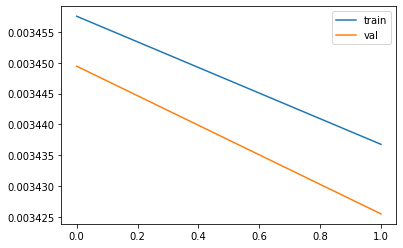

In [60]:
plt.plot(trainer.loss["train"], label="train")
plt.plot(trainer.loss["val"], label="val")
plt.legend()
plt.show()

## Visualization

In [86]:
for data in train_dataloader:
    inputs = data["image"]
    labels = data["heatmaps"]

    if config["cuda"]:
        inputs = inputs.cuda()
        labels = labels.cuda()

    outputs = model(inputs)
    break

inputs = inputs.numpy()
outputs = outputs.detach().numpy()

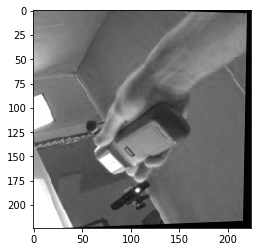

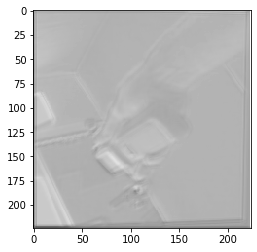

In [89]:
plt.imshow(inputs[1, 0, :, :], cmap="gray")
plt.show()
plt.imshow(outputs[1, 0, :, :], cmap="gray")
plt.show()